#PRICE PREDICTION FOR NILA (ECERAN)

##Import Some Modules

In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from dataclasses import dataclass

#if importing csv from google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Load dataset
df1 = pd.read_csv('NilaEcerJatim.csv', sep =',')

#PREPROCESSING

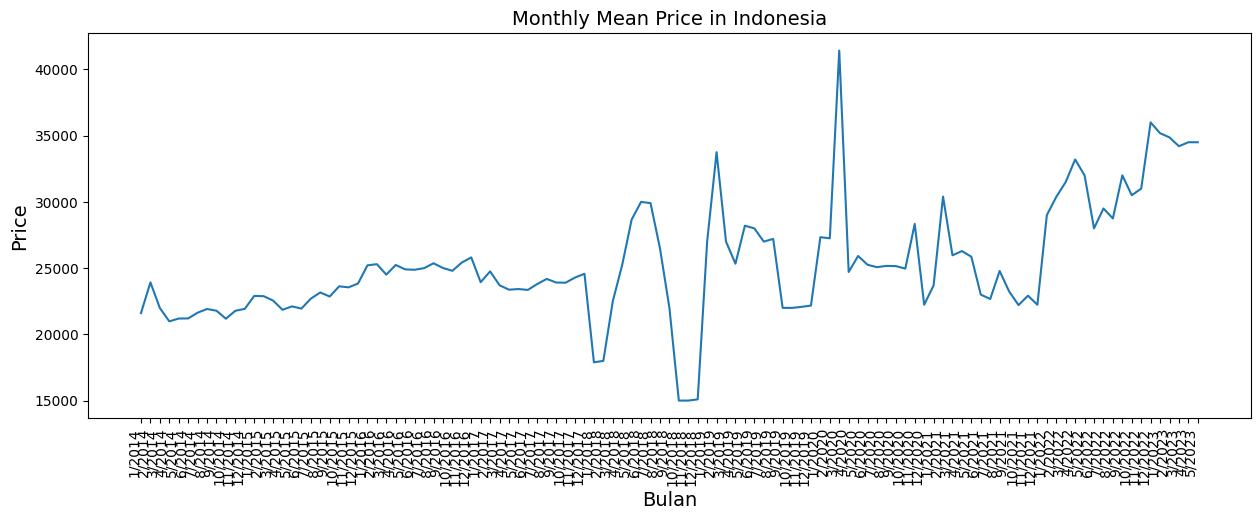

In [ ]:
plt.figure(figsize=(15,5))
gambar = plt.plot(df1['Bulan'], df1['Harga'])
plt.title('Monthly Mean Price in Indonesia', size = 14)
plt.ylabel('Price', size=14)
plt.xlabel('Bulan', size=14)
plt.xticks(rotation=90,ha='right')
plt.show()

From the chart above it can be seen that there may be outliers.

##Detecting and Changing Outlier (According to Window Size)

*   Outliers are extreme values that stand out greatly from the overall pattern of values in a dataset or graph.
*   Median is the value in the middle of a data set.
* We can use the IQR method of identifying outliers to set up a “fence” outside of Q1 and Q3. Any values that fall outside of this fence are considered outliers. To build this fence we take 1.5 times the IQR and then subtract this value from Q1 and add this value to Q3.
* We replace the extreme values with the mode value, we can use median or mean
 value but it is advised not to use the mean values because it is highly susceptible to outliers.
*  Median per window batch can be effective in identifying outliers within a specific window batch. If the goal is to identify and handle outliers, using the median per window batch can help in detecting and potentially removing or treating those outliers.

In [ ]:
def remove_outlier(df1):
  Q1 = df1['Harga'].quantile(0.25)
  Q3 = df1['Harga'].quantile(0.75)
  IQR = Q3 - Q1
  threshold = 1.5*IQR
  median = np.median(df1['Harga'])
  outliers = (df1['Harga'] < Q1 - threshold) | (df1['Harga'] > Q3 + threshold)
  df1[outliers] = median
  return df1

data = pd.read_csv('NilaEcerJatim.csv', sep =',')

new_data = np.array_split(data, 6) #split thhe data

df=pd.DataFrame()
for i in range(len(new_data)):
  new_data[i] = remove_outlier(new_data[i])

df = pd.concat(new_data)

##Taking Data

In [ ]:
def get_data(data):
    
    times = []
    value = []

    i = 0
    for row in data:
      times.append(i)
      value.append(float(row)/1000)
      i+=1

    
    return times, value

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    FILE_CSV = 'NilaEcerRaw.csv'
    times, price = get_data(df['Harga'])
    TIME = np.array(times)
    SERIES = np.array(price)
    SPLIT_TIME = 100
    WINDOW_SIZE = 6
    BATCH_SIZE = 6
    SHUFFLE_BUFFER_SIZE = 10


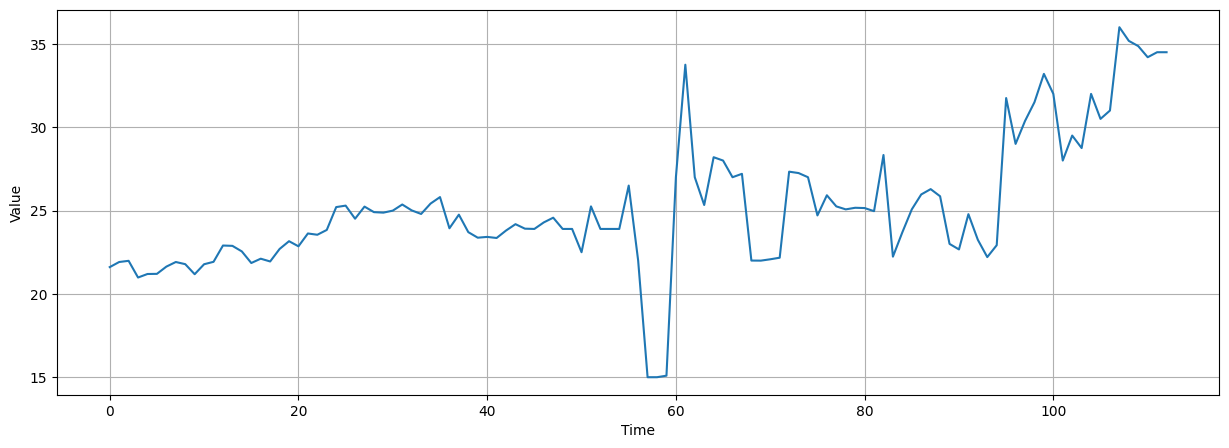

In [ ]:
plt.figure(figsize=(15, 5))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [ ]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [ ]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

#BUILD THE MODEL

The code snippet provided defines a function `create_model()` that creates a sequential model using the Keras API in TensorFlow. The model architecture is designed for time series forecasting or sequence prediction tasks. Here's a breakdown of the layers in the model:

1. Conv1D layer: This layer performs a 1-dimensional convolution operation on the input data. It uses 32 filters with a kernel size of 3, applying the "causal" padding to preserve the temporal ordering of the sequence. The activation function used is ReLU.

2. Bidirectional LSTM layers: A bidirectional Long Short-Term Memory (LSTM) layer with 32 units. This layer allows the model to learn from both forward and backward sequences.

3. Dense layers: There is one dense layers in the model. The dense layer has 1 unit, which is the output layer of the model.

4. Lambda layer: The lambda layer applies a scaling operation on the output of the model. It multiplies the output by 100, potentially to rescale the predictions based on the specific problem or desired range.

After defining the model architecture, the `create_model()` function returns the created model. Then, the `model.summary()` function is called to display a summary of the model's architecture, including the layer types, output shapes, and number of parameters. This summary provides a useful overview of the model's structure and can help in verifying that the model is constructed as intended.

In [ ]:
def create_model():
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100)
    ]) 

    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 32)             128       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 16,833
Trainable params: 16,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Test your uncompiled model
uncompiled_model = create_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

16/16 [==============================] - 1s 17ms/step
Your current architecture is compatible with the windowed dataset! :)


Finding the best learning rate:

In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
16/16 [==============================] - 5s 14ms/step - loss: 26.7223 - lr: 1.0000e-08
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 25.3356 - lr: 1.1220e-08
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 23.5504 - lr: 1.2589e-08
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 21.6956 - lr: 1.4125e-08
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 19.8847 - lr: 1.5849e-08
Epoch 6/100
16/16 [==============================] - 0s 12ms/step - loss: 18.1370 - lr: 1.7783e-08
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 16.4171 - lr: 1.9953e-08
Epoch 8/100
16/16 [==============================] - 0s 10ms/step - loss: 14.6876 - lr: 2.2387e-08
Epoch 9/100
16/16 [==============================] - 0s 10ms/step - loss: 12.8970 - lr: 2.5119e-08
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 11.0033 - lr: 2.8184e-08
Epoch 11/100

(1e-08, 0.001, 0.0, 50.0)

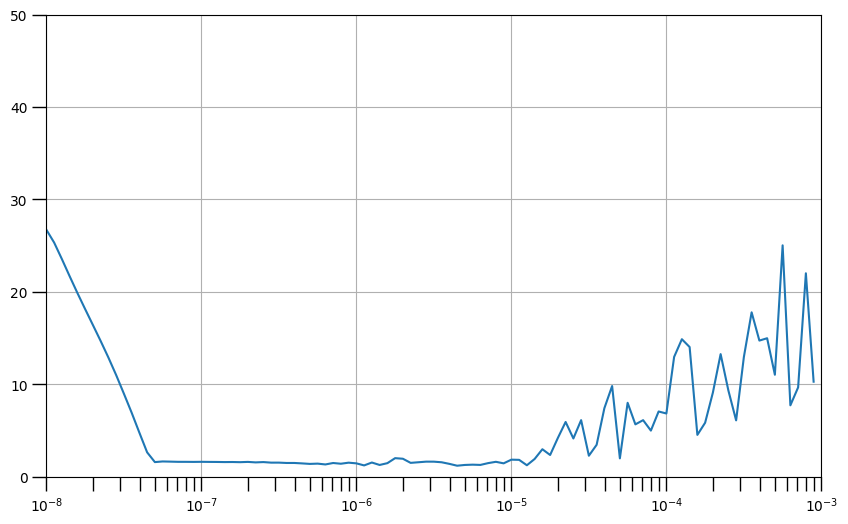

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

Based on the graph above, the recommended learning rate are 1e-7 or 1e-6

In [ ]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
Epochs = 100
history = model.fit(train_set,epochs=Epochs)

Epoch 1/100
16/16 [==============================] - 3s 5ms/step - loss: 11.5594 - mae: 12.0474
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 5.5813 - mae: 6.0810
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 1.8742 - mae: 2.3083
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 1.7914 - mae: 2.2229
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 2.4598 - mae: 2.9206
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 2.1179 - mae: 2.5701
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 2.2394 - mae: 2.7120
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 2.1568 - mae: 2.6192
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 1.7324 - mae: 2.1773
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 1.6820 - mae: 2.1276
Epoch 11/100
16/16 [==============================] - 0s 

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

#EVALUATE THE MODEL

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [ ]:
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
cnn_forecast = cnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
mse, mae = compute_metrics(series_valid, cnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

18/18 [==============================] - 1s 3ms/step
mse: 5.04, mae: 1.63 for forecast


MAE: 1.63 implies that, on average, the forecast's distance from the true value is 1.63 (Rp1.630)

18/18 [==============================] - 0s 4ms/step


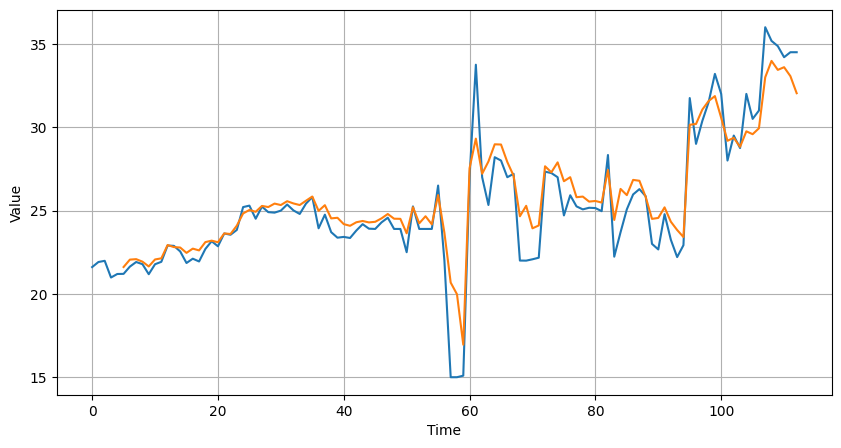

In [ ]:
# Compute the forecast for all the series
cnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE, G.BATCH_SIZE).squeeze()
tam = [None,None,None,None,None] 


# Slice the forecast to get only the predictions for the validation set
cnn_forecast = np.insert(cnn_forecast, 0, tam)

# Plot the forecast
plt.figure(figsize=(10, 5))
plot_series(G.TIME, G.SERIES)
plot_series(G.TIME, cnn_forecast)

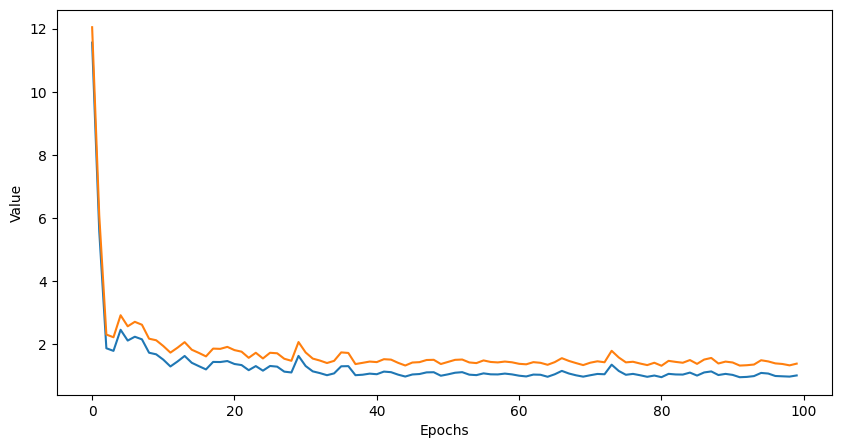

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(range(10), history.history["loss"][:10])
#plt.plot(range(10), history.history["mae"][:10])
plt.plot(history.history["loss"])
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("Value")

plt.show()

#FORECASTING

In [ ]:
# prepare data for forecasting
last_window = G.SERIES[-G.WINDOW_SIZE:]
last_window = np.reshape(last_window, (1, G.WINDOW_SIZE, 1))

# make a forecast for n steps ahead
forecast_norm = []
for _ in range(3):
    pred = model.predict(last_window)[0, 0]
    forecast_norm.append(pred)
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = pred


forecast = forecast_norm
print("Forecast:", forecast)

1/1 [==============================] - 0s 16ms/step
Forecast: [32.04021, 31.236952, 30.326637]


#SAVING MODEL

In [ ]:
model.save('nilaecerjatimlower.h5')

#REFERENSI

* coursera
* https://medium.com/analytics-vidhya/identifying-cleaning-and-replacing-outliers-titanic-dataset-20182a062893
* https://online.stat.psu.edu/stat200/lesson/3/3.2#:~:text=We%20can%20use%20the%20IQR,add%20this%20value%20to%20Q3.